NUS Graded Assignment 3.1: ANN for Medical Diagnosis

Syed Salman Rabbani

In [3]:
# Task 1: Utilise Libraries/Dataset

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


from google.colab import files
uploaded = files.upload()

import io
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

df.head()



Saving enhanced_diabetes_dataset.csv to enhanced_diabetes_dataset.csv


,Age,Gender,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,HbA1c,FastingBS,Triglycerides,HDL,Smoking,PhysicalActivity,Prediabetes,Diabetes
0,52,1,1,124,95.0,20.0,0,36.0,0.078,4.7,87,142.0,37.0,0,3.3,0,1
1,43,1,2,144,86.0,23.0,3,32.9,0.118,6.3,135,162.0,89.0,0,5.2,1,1
2,55,1,4,141,113.0,18.0,297,43.4,0.139,5.4,113,180.0,45.0,1,0.0,1,0
3,68,1,3,125,110.0,32.0,210,22.7,0.197,5.2,93,262.0,56.0,0,4.1,0,1
4,41,0,0,177,92.0,14.0,189,38.1,0.078,10.5,126,332.0,66.0,0,3.8,0,1


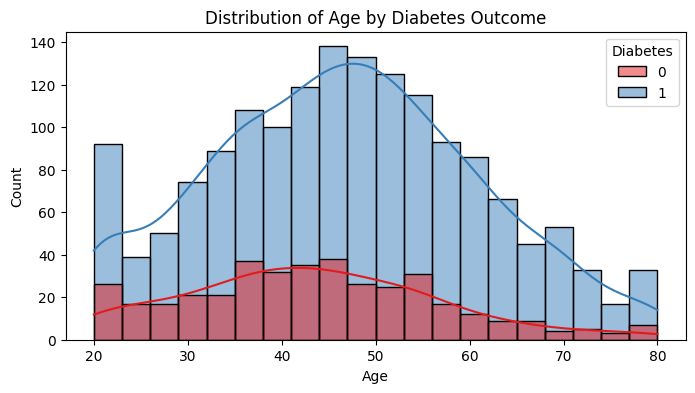

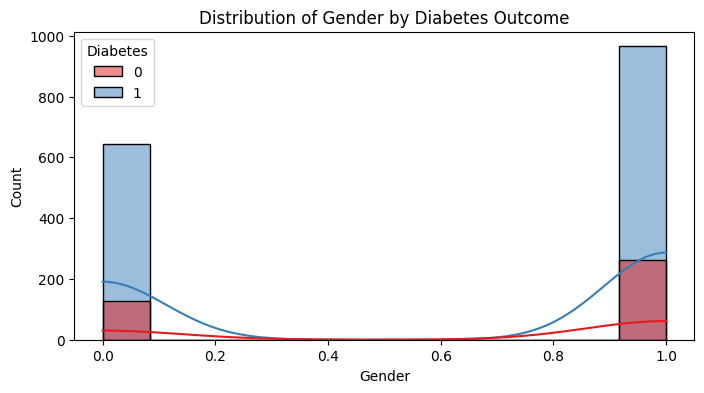

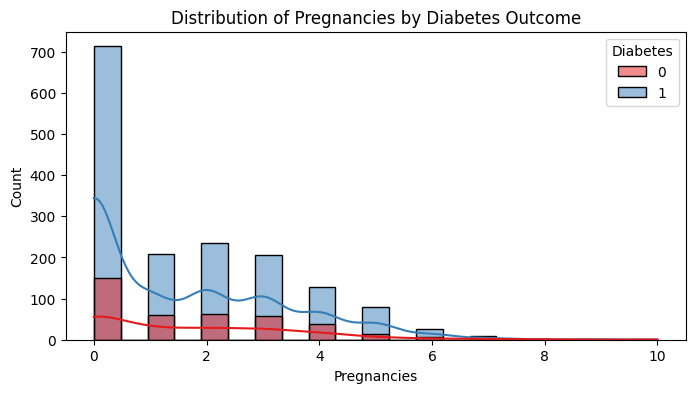

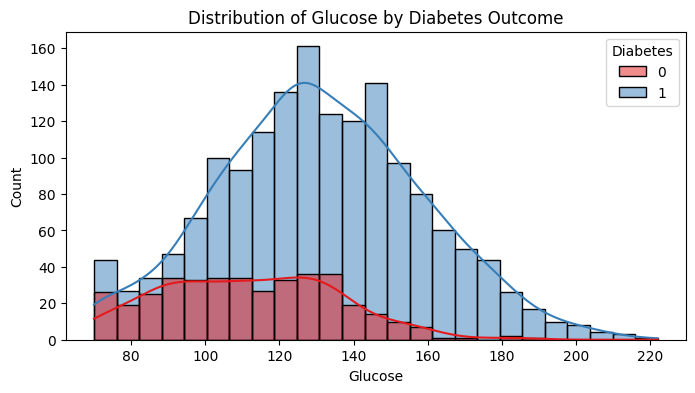

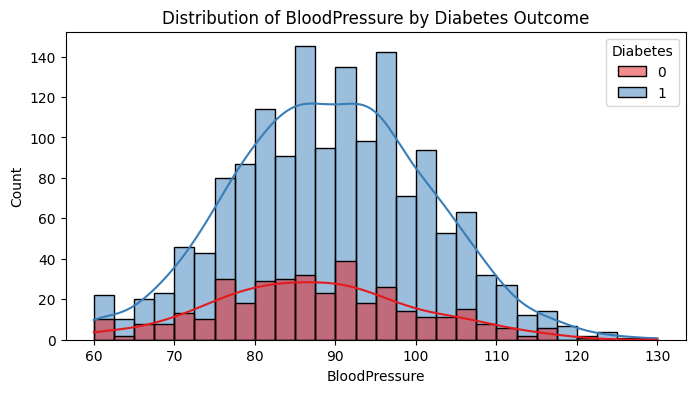

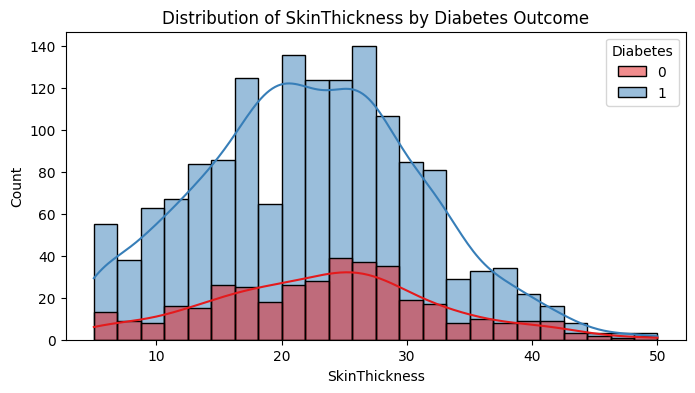

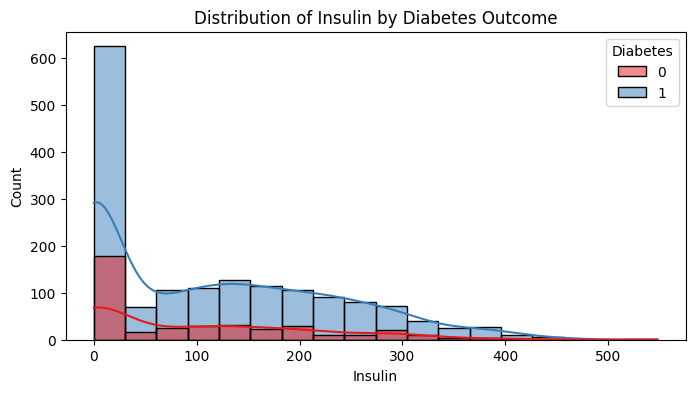

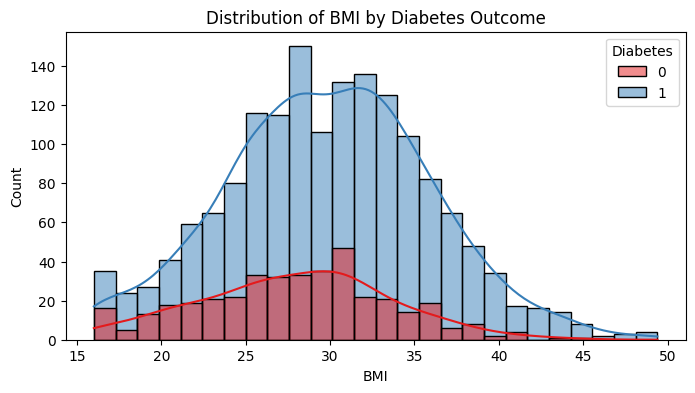

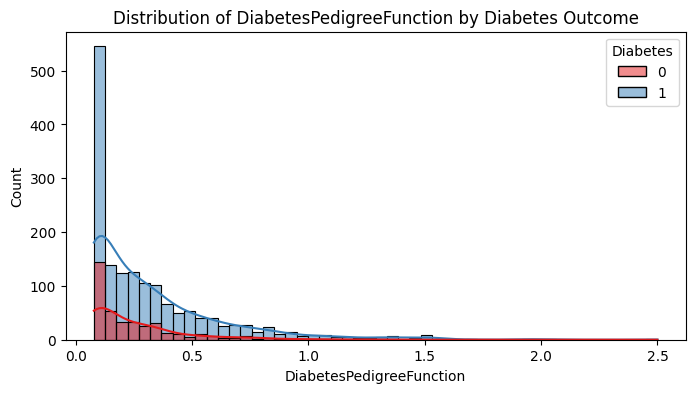

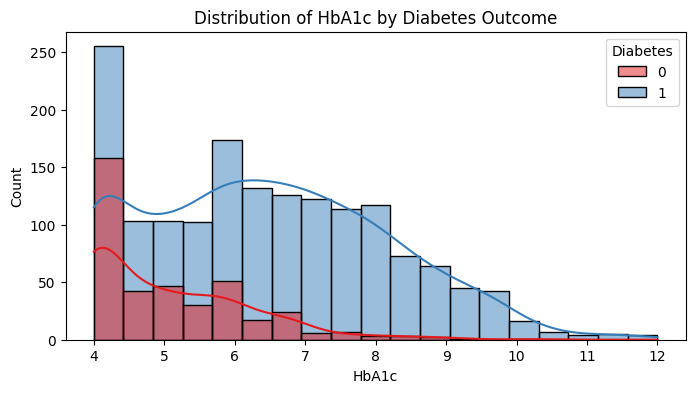

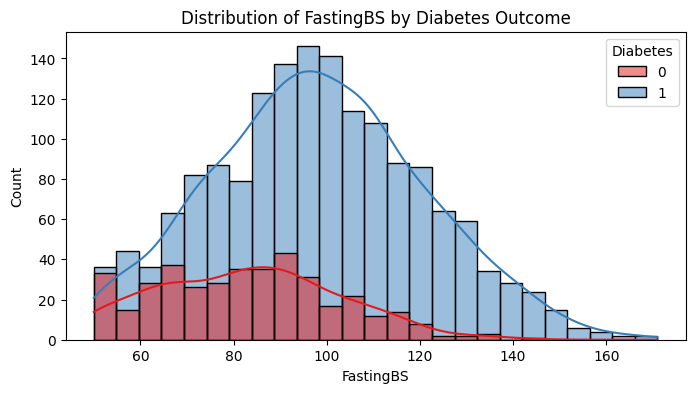

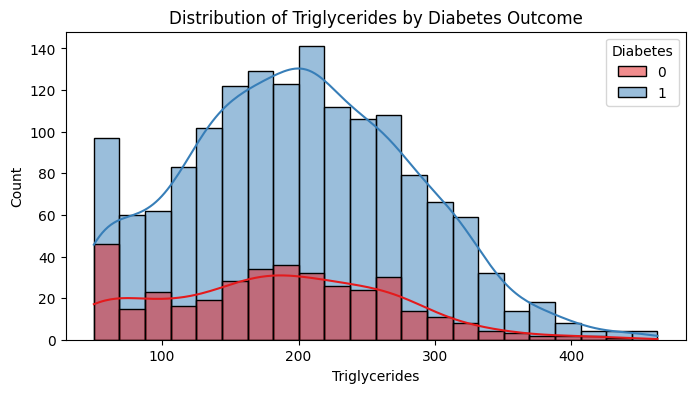

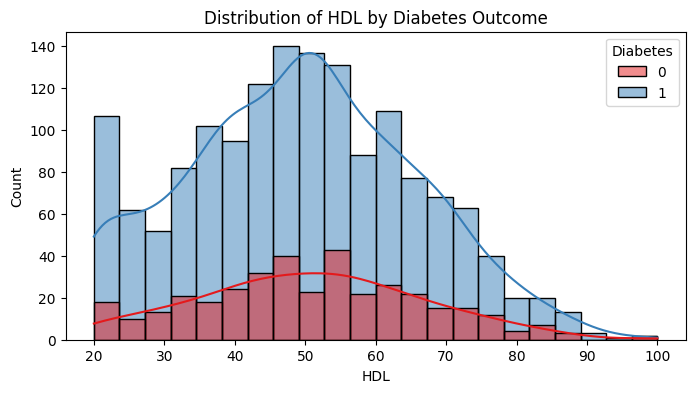

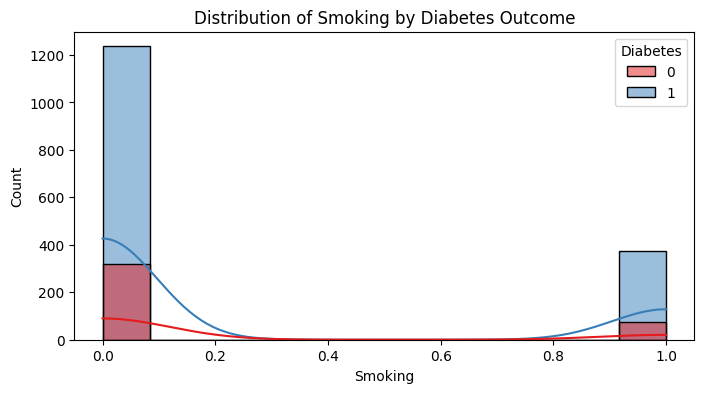

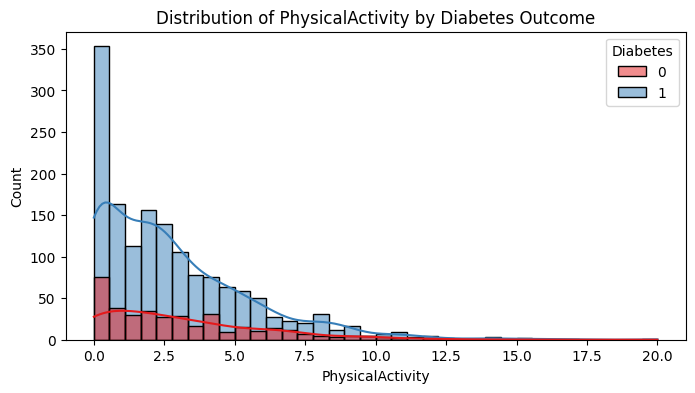

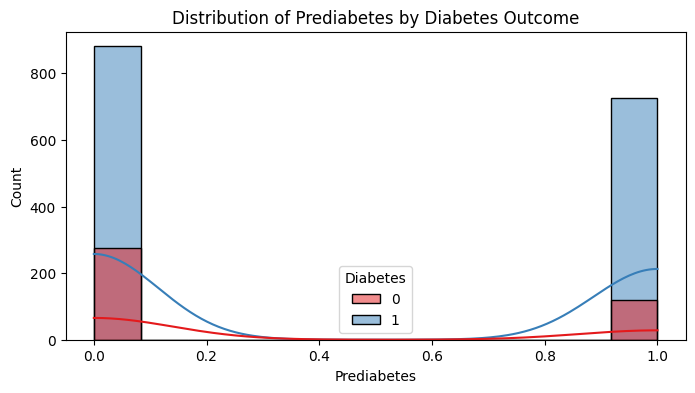

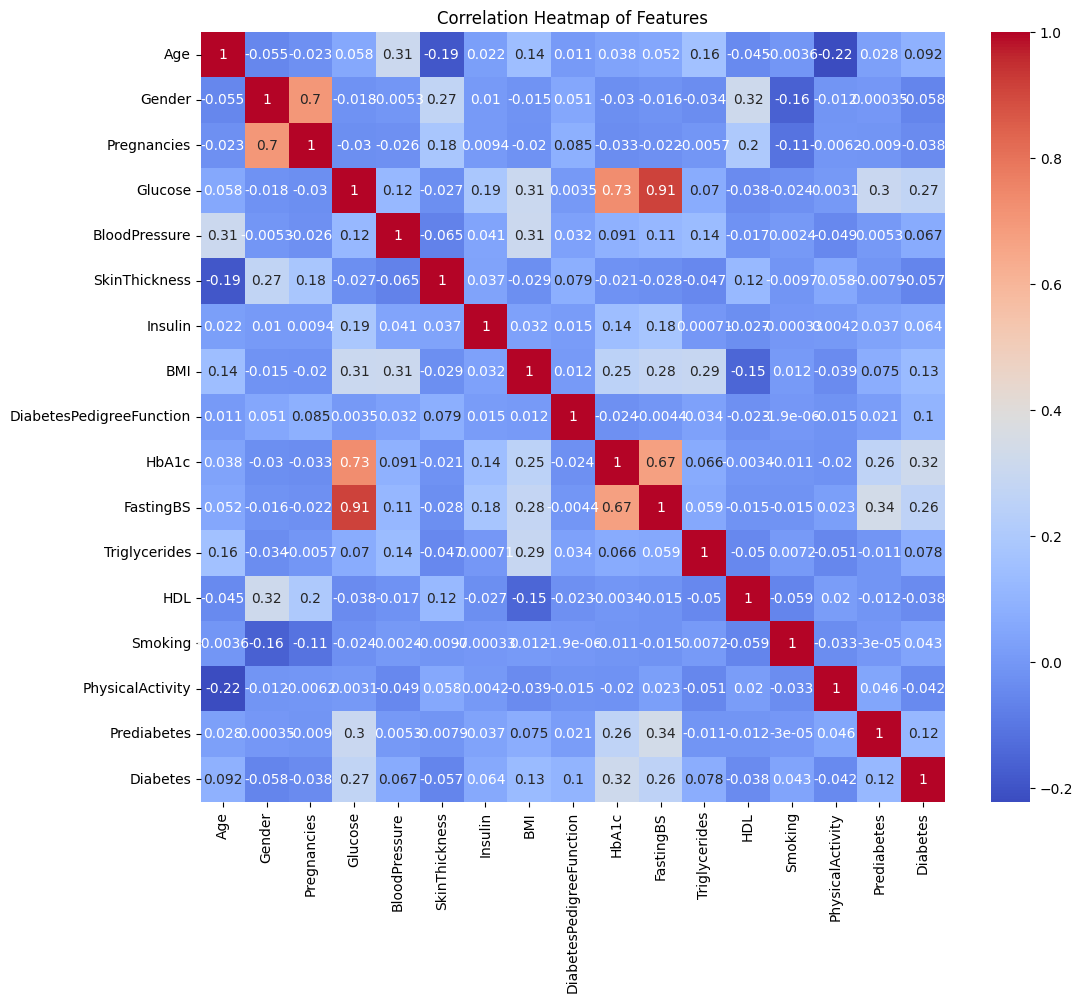

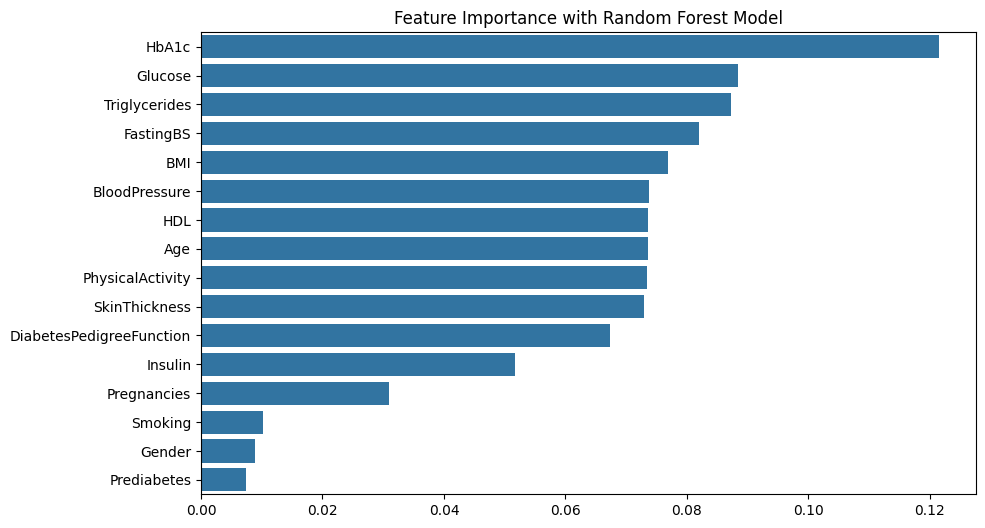

In [4]:
# Task 2: Generate at least three EDA visualisations

# Distribution plots comparing features between diabetic and non-diabetic patients
features = df.columns[:-1]
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue=df.columns[-1], kde=True, palette='Set1')
    plt.title(f'Distribution of {feature} by Diabetes Outcome')
    plt.show()

# For Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

# Feature importance , I am using Random Forest here
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=[df.columns[-1]])
y = df[df.columns[-1]]

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = [features[i] for i in indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features_sorted)
plt.title('Feature Importance with Random Forest Model')
plt.show()

SkinThickness has 0 zero values.
Insulin has 737 zero values.
BMI has 0 zero values.
SkinThickness after replacement has 0 zero values.
Insulin after replacement has 0 zero values.
BMI after replacement has 0 zero values.


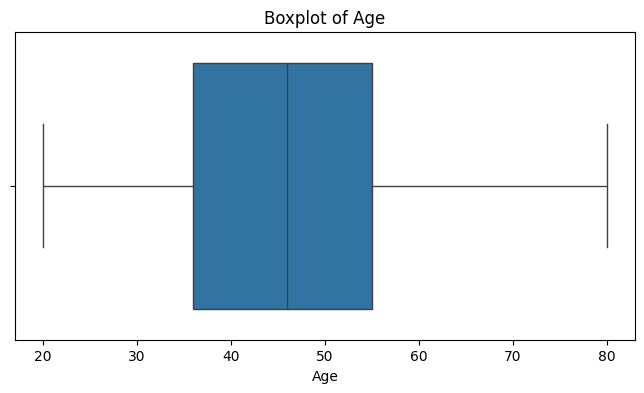

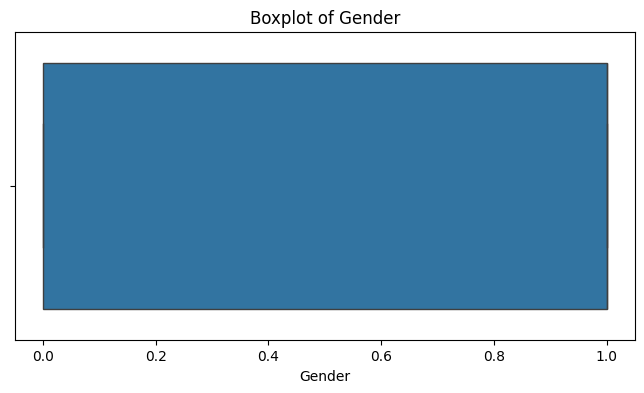

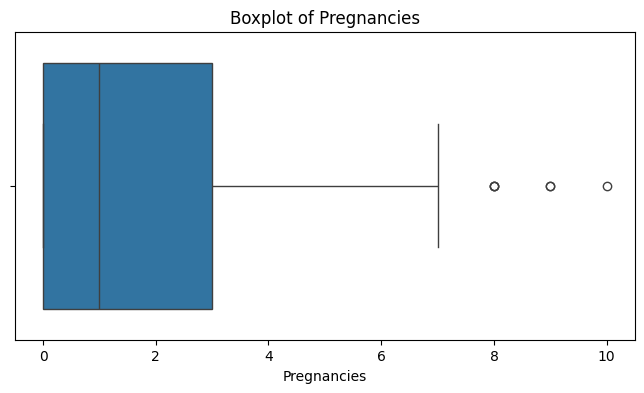

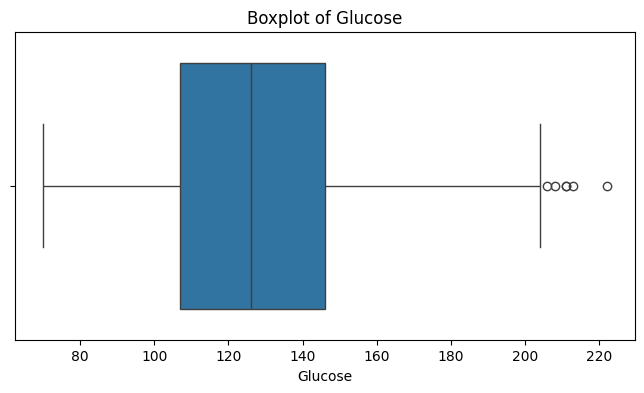

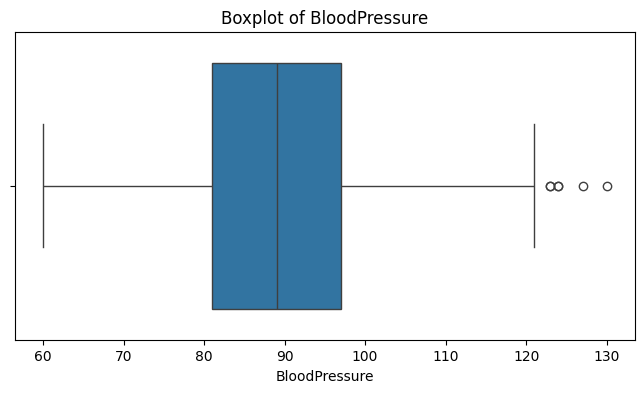

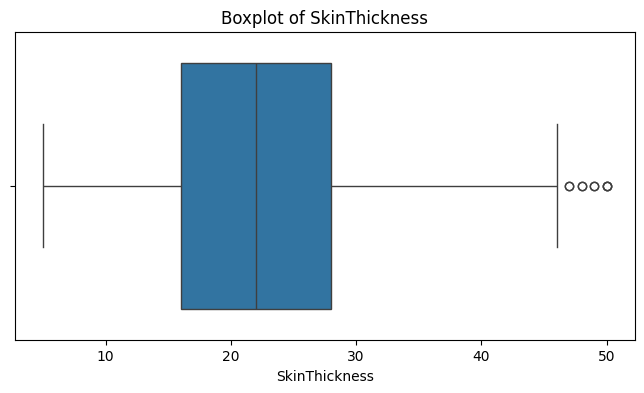

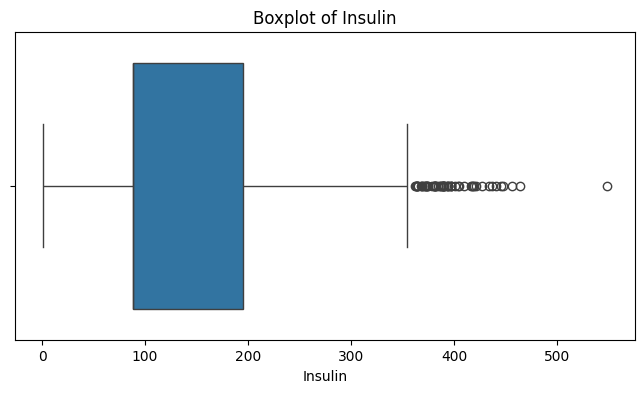

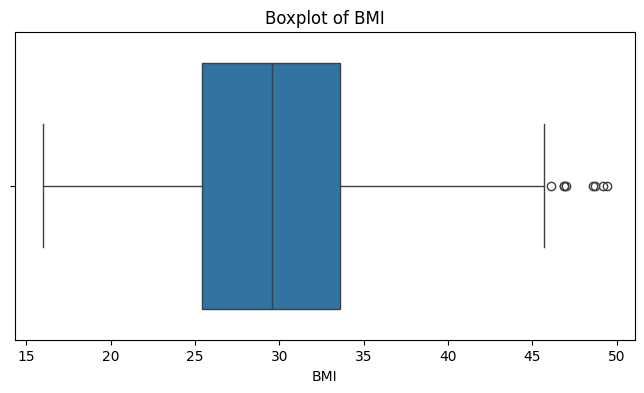

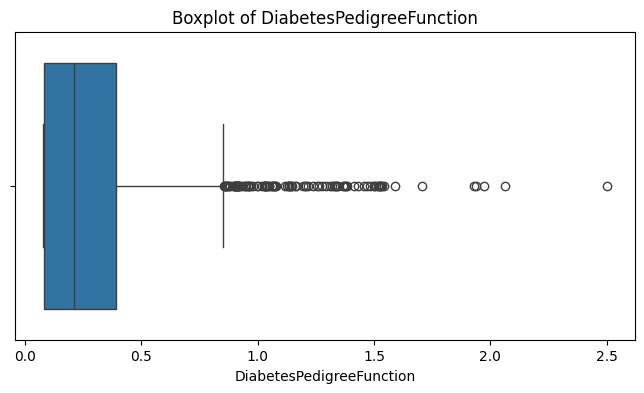

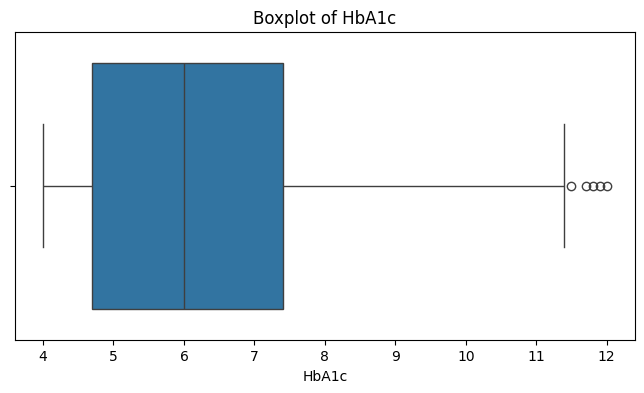

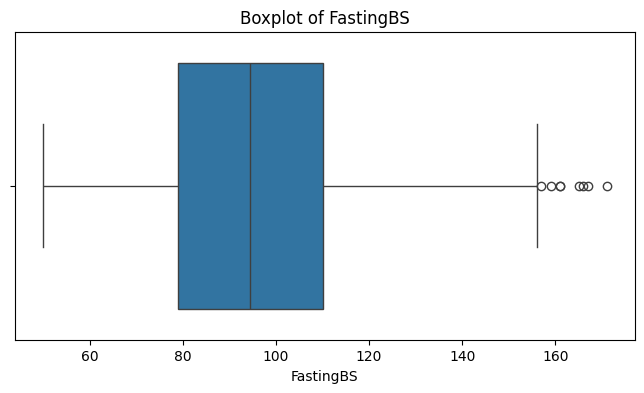

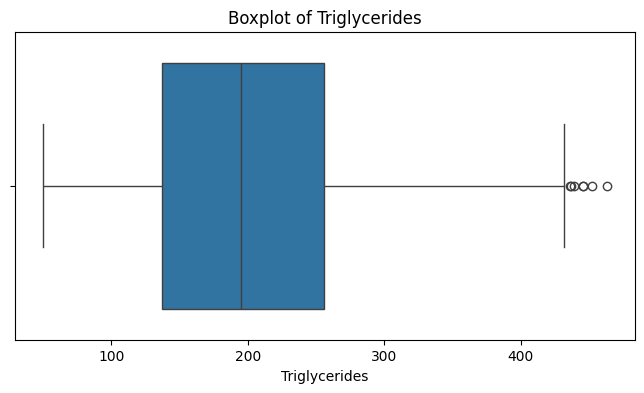

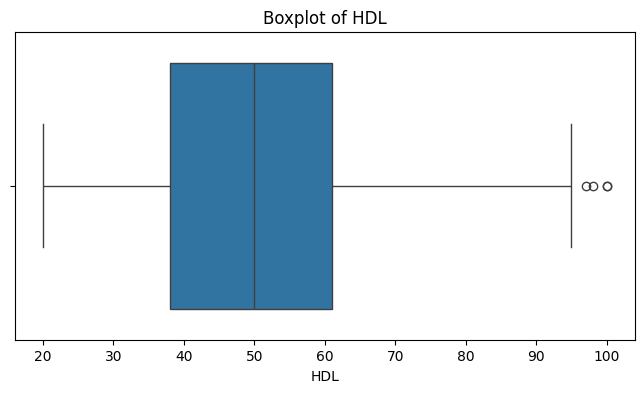

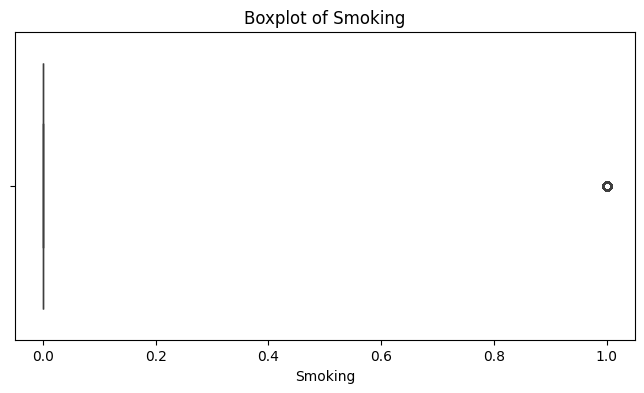

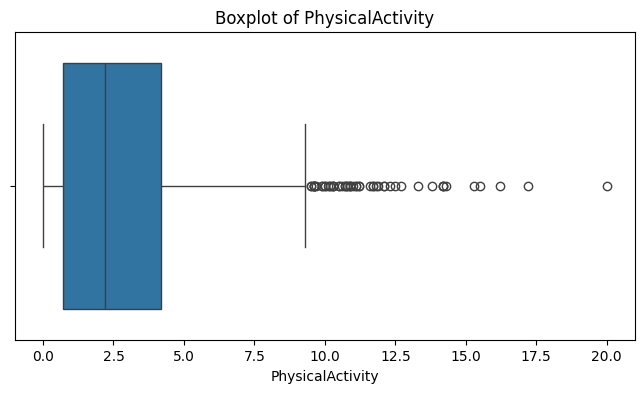

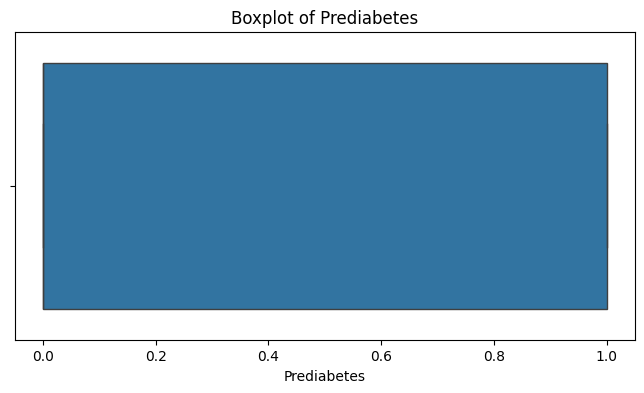

In [5]:
# Task 3: Analyse data quality

# To Check for missing or zero values
zero_features = ['SkinThickness', 'Insulin', 'BMI']
for feature in zero_features:
    missing_count = (df[feature] == 0).sum()
    print(f"{feature} has {missing_count} zero values.")

# Replace zero values with median to level up the data
for feature in zero_features:
    median = df[feature].median()
    df[feature] = df[feature].replace(0, median)

# Verifying if zeros are replaced
for feature in zero_features:
    missing_count = (df[feature] == 0).sum()
    print(f"{feature} after replacement has {missing_count} zero values.")

# Outlier detection using boxplots
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

In [7]:
# Trying to handle outliers using capping via Winsorization
for feature in features:
    lower_bound = df[feature].quantile(0.01)
    upper_bound = df[feature].quantile(0.99)
    df[feature] = np.clip(df[feature], lower_bound, upper_bound)

In [8]:
# Task 4: Prepare Features and Target Variable

# Split features (X) and target (y)
X = df.drop(columns=[df.columns[-1]])  # All columns except the last one
y = df[df.columns[-1]]  # Last column (Outcome)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardized. Shape of X_scaled:", X_scaled.shape)

Features standardized. Shape of X_scaled: (2000, 16)


Class distribution:
Diabetes
1    1608
0     392
Name: count, dtype: int64


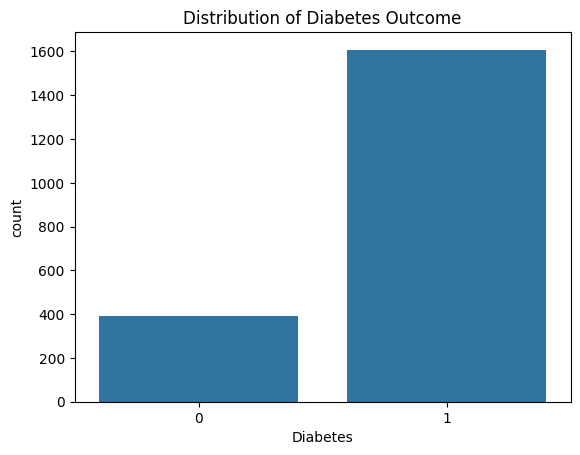

Any NaNs in features?: False
Total NaNs in dataset: 0
NaNs fixed. Ready for SMOTE.
After SMOTE class distribution:
Diabetes
1    1608
0    1608
Name: count, dtype: int64
Shapes:
X_train: (2250, 16)
X_val: (483, 16)
X_test: (483, 16)


In [13]:
# Task 5: Class Imbalance and Dataset Splitting

# Checking class distribution
print("Class distribution:")
print(y.value_counts())

sns.countplot(x=y)
plt.title('Distribution of Diabetes Outcome')
plt.show()


# Check for any NaNs
print("Any NaNs in features?:", np.isnan(X_scaled).any())

# Number of NaNs
print("Total NaNs in dataset:", np.isnan(X_scaled).sum())

# Filling NaNs with 0
X_scaled = np.nan_to_num(X_scaled)

print("NaNs fixed. Ready for SMOTE.")



# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("After SMOTE class distribution:")
print(pd.Series(y_resampled).value_counts())

# Splitting into training (70%), validation (15%), test (15%) as in the assignment ask
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1765, random_state=42, stratify=y_train_full)  # 0.1765 of 85% ≈ 15%

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


In [14]:
# Task 6: Design an Appropriate ANN Architecture

# Model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer: 1 neuron with sigmoid for binary classification
])

# Model summary
model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Task 7: Configure the Training Process

# Rebuilding model with dropout and L2 regularization
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Task 8: Train the model with appropriate batch size and number of epochs & implementing callback

# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Fitting the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5991 - loss: 0.7507 - precision: 0.6250 - recall: 0.5631

71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5998 - loss: 0.7503 - precision: 0.6254 - recall: 0.5639 - val_accuracy: 0.7308 - val_loss: 0.6352 - val_precision: 0.7478 - val_recall: 0.6983 - learning_rate: 0.0010
Epoch 2/100
68/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7055 - loss: 0.6662 - precision: 0.7001 - recall: 0.6705

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7058 - loss: 0.6656 - precision: 0.7017 - recall: 0.6707 - val_accuracy: 0.7329 - val_loss: 0.6033 - val_precision: 0.7467 - val_recall: 0.7066 - learning_rate: 0.0010
Epoch 3/100
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7234 - loss: 0.6452 - precision: 0.7103 - recall: 0.7099

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7237 - loss: 0.6438 - precision: 0.7121 - recall: 0.7101 - val_accuracy: 0.7516 - val_loss: 0.5856 - val_precision: 0.7905 - val_recall: 0.6860 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7362 - loss: 0.6051 - precision: 0.7637 - recall: 0.7060

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7362 - loss: 0.6052 - precision: 0.7636 - recall: 0.7059 - val_accuracy: 0.7660 - val_loss: 0.5766 - val_precision: 0.8146 - val_recall: 0.6901 - learning_rate: 0.0010
Epoch 5/100
66/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7541 - loss: 0.6056 - precision: 0.7986 - recall: 0.6907

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7541 - loss: 0.6052 - precision: 0.7971 - recall: 0.6921 - val_accuracy: 0.7660 - val_loss: 0.5703 - val_precision: 0.8146 - val_recall: 0.6901 - learning_rate: 0.0010
Epoch 6/100
65/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7585 - loss: 0.5750 - precision: 0.7809 - recall: 0.6985

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7581 - loss: 0.5760 - precision: 0.7804 - recall: 0.7002 - val_accuracy: 0.7640 - val_loss: 0.5648 - val_precision: 0.8137 - val_recall: 0.6860 - learning_rate: 0.0010
Epoch 7/100
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7524 - loss: 0.5813 - precision: 0.8036 - recall: 0.6904

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7525 - loss: 0.5812 - precision: 0.8033 - recall: 0.6906 - val_accuracy: 0.7660 - val_loss: 0.5631 - val_precision: 0.8274 - val_recall: 0.6736 - learning_rate: 0.0010
Epoch 8/100
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7643 - loss: 0.5805 - precision: 0.7767 - recall: 0.7178

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7641 - loss: 0.5803 - precision: 0.7782 - recall: 0.7163 - val_accuracy: 0.7681 - val_loss: 0.5569 - val_precision: 0.8009 - val_recall: 0.7149 - learning_rate: 0.0010
Epoch 9/100
50/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7804 - loss: 0.5669 - precision: 0.7893 - recall: 0.7548

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7755 - loss: 0.5677 - precision: 0.7900 - recall: 0.7444 - val_accuracy: 0.7660 - val_loss: 0.5552 - val_precision: 0.8146 - val_recall: 0.6901 - learning_rate: 0.0010
Epoch 10/100
49/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7693 - loss: 0.5497 - precision: 0.7913 - recall: 0.7059

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7689 - loss: 0.5487 - precision: 0.7940 - recall: 0.7090 - val_accuracy: 0.7702 - val_loss: 0.5519 - val_precision: 0.8227 - val_recall: 0.6901 - learning_rate: 0.0010
Epoch 11/100
69/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - loss: 0.5380 - precision: 0.8125 - recall: 0.7255

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7877 - loss: 0.5383 - precision: 0.8123 - recall: 0.7258 - val_accuracy: 0.7702 - val_loss: 0.5419 - val_precision: 0.8075 - val_recall: 0.7107 - learning_rate: 0.0010
Epoch 12/100
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7701 - loss: 0.5426 - precision: 0.8094 - recall: 0.7225

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7706 - loss: 0.5423 - precision: 0.8101 - recall: 0.7220 - val_accuracy: 0.7702 - val_loss: 0.5408 - val_precision: 0.8164 - val_recall: 0.6983 - learning_rate: 0.0010
Epoch 13/100
49/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8104 - loss: 0.5192 - precision: 0.8518 - recall: 0.7458

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8042 - loss: 0.5226 - precision: 0.8435 - recall: 0.7439 - val_accuracy: 0.7681 - val_loss: 0.5378 - val_precision: 0.8095 - val_recall: 0.7025 - learning_rate: 0.0010
Epoch 14/100
67/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7831 - loss: 0.5245 - precision: 0.8181 - recall: 0.7265

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7829 - loss: 0.5251 - precision: 0.8180 - recall: 0.7263 - val_accuracy: 0.7785 - val_loss: 0.5353 - val_precision: 0.8325 - val_recall: 0.6983 - learning_rate: 0.0010
Epoch 15/100
50/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8016 - loss: 0.5160 - precision: 0.8543 - recall: 0.7305

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7975 - loss: 0.5196 - precision: 0.8466 - recall: 0.7290 - val_accuracy: 0.7702 - val_loss: 0.5345 - val_precision: 0.7991 - val_recall: 0.7231 - learning_rate: 0.0010
Epoch 16/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7997 - loss: 0.5122 - precision: 0.8237 - recall: 0.7592 - val_accuracy: 0.7660 - val_loss: 0.5364 - val_precision: 0.8413 - val_recall: 0.6570 - learning_rate: 0.0010
Epoch 17/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7953 - loss: 0.5247 - precision: 0.8481 - recall: 0.6999 - val_accuracy: 0.7805 - val_loss: 0.5350 - val_precision: 0.8469 - val_recall: 0.6860 - learning_rate: 0.0010
Epoch 18/100
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7840 - loss: 0.5127 - precision: 0.8295 - recall: 0.7300

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7840 - loss: 0.5125 - precision: 0.8294 - recall: 0.7298 - val_accuracy: 0.7743 - val_loss: 0.5285 - val_precision: 0.8122 - val_recall: 0.7149 - learning_rate: 0.0010
Epoch 19/100
48/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7935 - loss: 0.5177 - precision: 0.8235 - recall: 0.7498

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7941 - loss: 0.5163 - precision: 0.8252 - recall: 0.7483 - val_accuracy: 0.7723 - val_loss: 0.5273 - val_precision: 0.8402 - val_recall: 0.6736 - learning_rate: 0.0010
Epoch 20/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7985 - loss: 0.4927 - precision: 0.8440 - recall: 0.7320 - val_accuracy: 0.7805 - val_loss: 0.5283 - val_precision: 0.8333 - val_recall: 0.7025 - learning_rate: 0.0010
Epoch 21/100
58/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7929 - loss: 0.5015 - precision: 0.8238 - recall: 0.7365

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7941 - loss: 0.5016 - precision: 0.8260 - recall: 0.7381 - val_accuracy: 0.7847 - val_loss: 0.5234 - val_precision: 0.8286 - val_recall: 0.7190 - learning_rate: 0.0010
Epoch 22/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8106 - loss: 0.4853 - precision: 0.8567 - recall: 0.7540 - val_accuracy: 0.7785 - val_loss: 0.5277 - val_precision: 0.8293 - val_recall: 0.7025 - learning_rate: 0.0010
Epoch 23/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7982 - loss: 0.4803 - precision: 0.8226 - recall: 0.7566 - val_accuracy: 0.7743 - val_loss: 0.5268 - val_precision: 0.8308 - val_recall: 0.6901 - learning_rate: 0.0010
Epoch 24/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7915 - loss: 0.4963 - precision: 0.8345 - recall: 0.7329 - val_accuracy: 0.7826 - val_loss: 0.5237 - val_precision: 0.8309 - val_recall: 0.7107 - learning_rate: 0.0010
Epoch 25/100
48/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8152 - loss

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8140 - loss: 0.4804 - precision: 0.8449 - recall: 0.7604 - val_accuracy: 0.7743 - val_loss: 0.5203 - val_precision: 0.7982 - val_recall: 0.7355 - learning_rate: 0.0010
Epoch 26/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7958 - loss: 0.5094 - precision: 0.8302 - recall: 0.7633 - val_accuracy: 0.7660 - val_loss: 0.5225 - val_precision: 0.8377 - val_recall: 0.6612 - learning_rate: 0.0010
Epoch 27/100
48/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8059 - loss: 0.4657 - precision: 0.8505 - recall: 0.7365

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8084 - loss: 0.4676 - precision: 0.8510 - recall: 0.7435 - val_accuracy: 0.7888 - val_loss: 0.5137 - val_precision: 0.8271 - val_recall: 0.7314 - learning_rate: 0.0010
Epoch 28/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7979 - loss: 0.4887 - precision: 0.8317 - recall: 0.7541 - val_accuracy: 0.7888 - val_loss: 0.5233 - val_precision: 0.8398 - val_recall: 0.7149 - learning_rate: 0.0010
Epoch 29/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8175 - loss: 0.4683 - precision: 0.8560 - recall: 0.7646 - val_accuracy: 0.7598 - val_loss: 0.5197 - val_precision: 0.8150 - val_recall: 0.6736 - learning_rate: 0.0010
Epoch 30/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8291 - loss: 0.4564 - precision: 0.8710 - recall: 0.7684 - val_accuracy: 0.7930 - val_loss: 0.5167 - val_precision: 0.8257 - val_recall: 0.7438 - learning_rate: 0.0010
Epoch 31/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8200 - loss

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8197 - loss: 0.4505 - precision: 0.8742 - recall: 0.7459 - val_accuracy: 0.7805 - val_loss: 0.5111 - val_precision: 0.8208 - val_recall: 0.7190 - learning_rate: 0.0010
Epoch 33/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8196 - loss: 0.4614 - precision: 0.8592 - recall: 0.7541 - val_accuracy: 0.7847 - val_loss: 0.5212 - val_precision: 0.8416 - val_recall: 0.7025 - learning_rate: 0.0010
Epoch 34/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8241 - loss: 0.4522 - precision: 0.8697 - recall: 0.7579 - val_accuracy: 0.7826 - val_loss: 0.5236 - val_precision: 0.8477 - val_recall: 0.6901 - learning_rate: 0.0010
Epoch 35/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8210 - loss: 0.4494 - precision: 0.8756 - recall: 0.7457 - val_accuracy: 0.7826 - val_loss: 0.5187 - val_precision: 0.8278 - val_recall: 0.7149 - learning_rate: 0.0010
Epoch 36/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8376 - loss

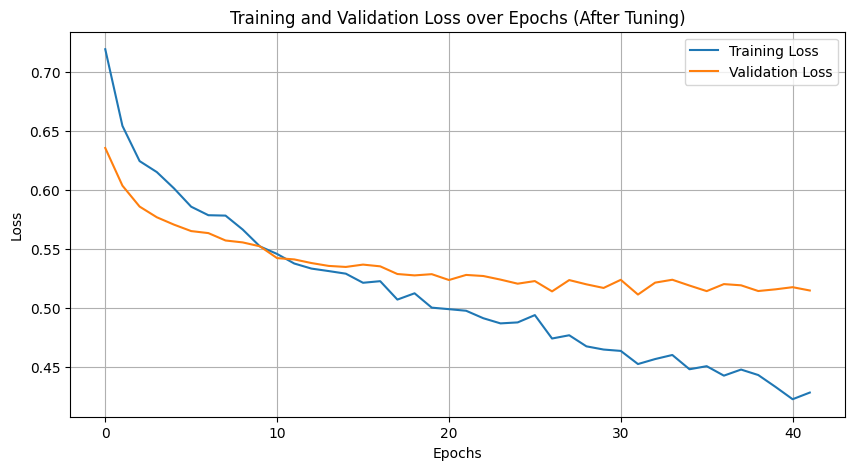

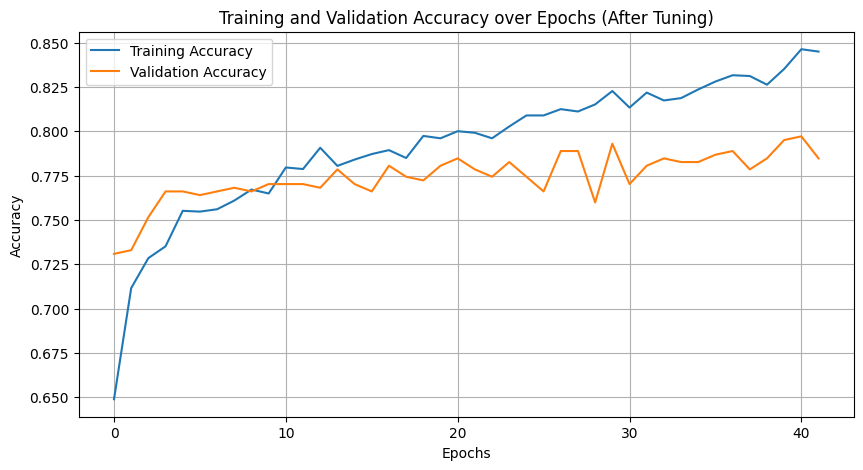

In [17]:
# Task 10: Visualize the Training Process

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs (After Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs (After Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Task 11: Tune Hyperparameters

# Define parameter grids
learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]
dropout_rate = 0.2  # Fixed at 0.2

# Record best results
best_val_accuracy = 0
best_params = {}

# Loop through combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"\nTraining model with learning rate {lr} and batch size {batch_size}")

        # Build model
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                         kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(dropout_rate),
            layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(dropout_rate),
            layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dense(1, activation='sigmoid')
        ])

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=batch_size,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
            verbose=0
        )

        val_accuracy = max(history.history['val_accuracy'])
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_params = {'learning_rate': lr, 'batch_size': batch_size}

print("\nBest Hyperparameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")



Training model with learning rate 0.01 and batch size 16
Validation Accuracy: 0.7785

Training model with learning rate 0.01 and batch size 32
Validation Accuracy: 0.8157

Training model with learning rate 0.001 and batch size 16
Validation Accuracy: 0.8178

Training model with learning rate 0.001 and batch size 32
Validation Accuracy: 0.8095

Best Hyperparameters:
{'learning_rate': 0.001, 'batch_size': 16}
Best Validation Accuracy: 0.8178


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 0.7495
Test Precision: 0.8125
Test Recall: 0.6473
Test F1-Score: 0.7206


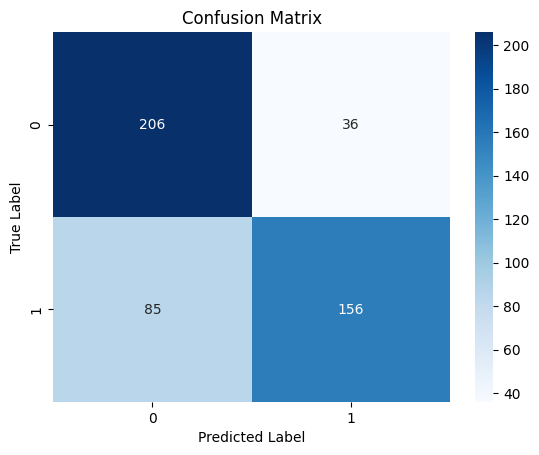

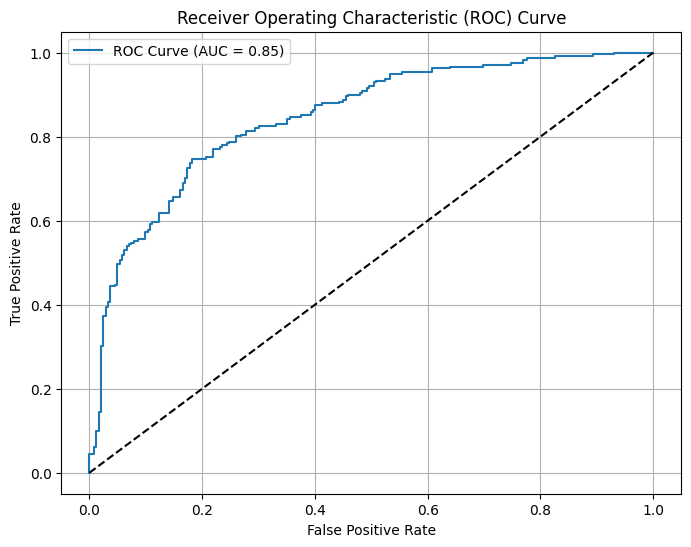

In [21]:
# Task 12: Evaluate the Model on the Test Dataset

# Assuming best_model and X_test, y_test are defined from earlier steps
# Evaluate model
# test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

# Predict probabilities
y_pred_probs = best_model.predict(X_test).ravel()

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics manually
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
